# BERT with HuggingFace Library

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi


Sun Apr 21 02:19:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from transformers import *  # this is HuggingFace library
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig

In [ ]:
# this will download the BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# this will download the BERT Trained Model
# output_hidden_states=False, as we are training & not interested in output state.
config = BertConfig.from_pretrained("bert-base-uncased",output_hidden_states=False) # dropout=0.2, attention_dropout=0.2
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### tokenize:
Converts a string in a sequence of tokens, using the tokenizer

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/Anuj_Depression_detection

/content/gdrive/MyDrive/Anuj_Depression_detection


In [5]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
train = pd.read_csv('sentiment_tweets3.csv',encoding = "ISO-8859-1")

In [6]:
train.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
train['label (depression result)'].value_counts()

0    8000
1    2314
Name: label (depression result), dtype: int64

In [ ]:
def clean_text(temp):
    temp=re.sub("@\S+", " ", temp)
    temp=re.sub("https*\S+", " ", temp)
    temp=re.sub("#\S+", " ", temp)
    temp=re.sub("\'\w+", '', temp)
    temp=re.sub(r'\w*\d+\w*', '', temp)
    temp=re.sub('\s{2,}', " ", temp)
    return temp.strip()

In [ ]:
train['message to examine'] = train['message to examine'].apply(clean_text)
sentences = train['message to examine']



In [ ]:
train.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga,0
2,220,-,0
3,288,"Need to send to my accountant tomorrow. Oddly,...",0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [ ]:
input_ids=[]
attention_masks=[]

for sent in tqdm(sentences):
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =128,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
target = np.array(pd.get_dummies(train['label (depression result)']))

100%|██████████| 10314/10314 [00:07<00:00, 1371.07it/s]


In [ ]:
bert_tokenizer.convert_ids_to_tokens(123)

'[unused118]'

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,train_mask,test_mask=train_test_split(input_ids,target,attention_masks,test_size=0.2)

In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def create_model(model_):
    input_ids = tf.keras.Input(shape=(128,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(128,),dtype='int32')

    output = model_(input_ids,attention_masks)
    output = output[0]      # this is inline in config.output_hidden_states as we want only the top head

    output = output[:,0,:]  #  We are only interested in <cls> or classification token of the model which can be extracted
                            #  using the slice operation. Now we have 2D data and build the network as one desired.
                            #  While converting 3D data to 2D we may miss on valuable info.

    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(2,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)


    for layer in model.layers[:3]:
        layer.trainable = False
    return model

model = create_model(bert_model)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_bert_model[2][0]        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit([X_train,train_mask],y_train,batch_size=32,epochs=10,validation_data=([X_test,test_mask],y_test))

Epoch 1/10
258/258 [==============================] - 69s 224ms/step - loss: 0.2975 - accuracy: 0.8703 - val_loss: 0.1016 - val_accuracy: 0.9636
Epoch 2/10
258/258 [==============================] - 55s 212ms/step - loss: 0.1159 - accuracy: 0.9585 - val_loss: 0.1003 - val_accuracy: 0.9627
Epoch 3/10
258/258 [==============================] - 55s 212ms/step - loss: 0.1066 - accuracy: 0.9639 - val_loss: 0.0843 - val_accuracy: 0.9675
Epoch 4/10
258/258 [==============================] - 55s 212ms/step - loss: 0.0899 - accuracy: 0.9664 - val_loss: 0.0852 - val_accuracy: 0.9719
Epoch 5/10
258/258 [==============================] - 55s 212ms/step - loss: 0.0906 - accuracy: 0.9694 - val_loss: 0.0805 - val_accuracy: 0.9685
Epoch 6/10
258/258 [==============================] - 55s 212ms/step - loss: 0.0807 - accuracy: 0.9728 - val_loss: 0.0813 - val_accuracy: 0.9714
Epoch 7/10
258/258 [==============================] - 55s 212ms/step - loss: 0.0827 - accuracy: 0.9714 - val_loss: 0.0739 - val_ac

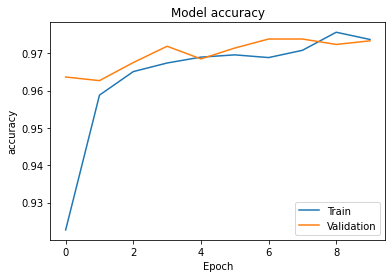

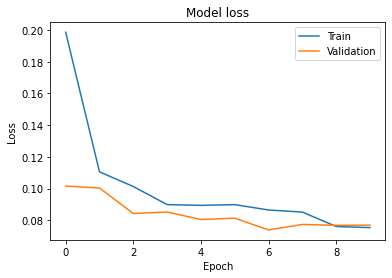

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def create_model(model_):

    input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')

    embedding_layer = model_(input_ids_in, attention_mask=input_masks_in)[0]
    # as 3D data is generated earlier embedding layer, we can use LSTM to extract great details
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
    # transformation of the 3D data into 2D so that FC layer can be used. A Pooling layer is used to perform this.
    X = tf.keras.layers.GlobalMaxPool1D()(X)
    X = tf.keras.layers.Dense(50, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(2, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

    for layer in model.layers[:3]:
        layer.trainable = False

    return model

model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128, 100)     327600      tf_bert_model[1][0]        

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit([X_train,train_mask],y_train,batch_size=32,epochs=10,validation_data=([X_test,test_mask],y_test))

Epoch 1/10
258/258 [==============================] - 251s 909ms/step - loss: 0.1900 - accuracy: 0.9200 - val_loss: 0.0488 - val_accuracy: 0.9850
Epoch 2/10
258/258 [==============================] - 232s 901ms/step - loss: 0.0409 - accuracy: 0.9892 - val_loss: 0.0409 - val_accuracy: 0.9874
Epoch 3/10
258/258 [==============================] - 233s 903ms/step - loss: 0.0245 - accuracy: 0.9934 - val_loss: 0.0327 - val_accuracy: 0.9889
Epoch 4/10
258/258 [==============================] - 232s 899ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0513 - val_accuracy: 0.9889
Epoch 5/10
258/258 [==============================] - 232s 901ms/step - loss: 0.0183 - accuracy: 0.9935 - val_loss: 0.0458 - val_accuracy: 0.9903
Epoch 6/10
258/258 [==============================] - 233s 905ms/step - loss: 0.0154 - accuracy: 0.9960 - val_loss: 0.0378 - val_accuracy: 0.9913
Epoch 7/10
258/258 [==============================] - 233s 903ms/step - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0345 -

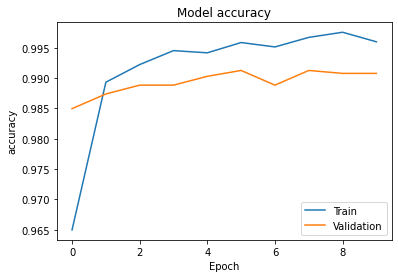

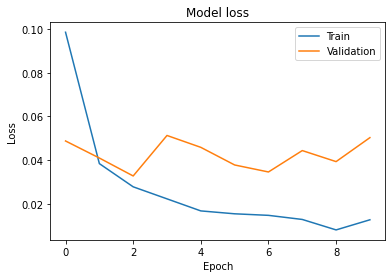

In [ ]:
import matplotlib.pyplot as plt
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()